# "Age Verification Using Computer Vision: Ensuring Compliance with Alcohol Laws for Good Seed Supermarkets"

## Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


## EDA

### Dataset Size

In [4]:
# check full dataset size

print("Dataset size:", labels.shape)
print("Number of images:", len(labels))

Dataset size: (7591, 2)
Number of images: 7591


### Check for Missing Values

In [5]:
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

### Check for Duplicates

In [6]:
labels.duplicated().sum()

0

In [7]:
labels['file_name'].duplicated().sum()

0

### Dataset Statistics

In [8]:
print('Age Statistics:')
labels['real_age'].describe()

Age Statistics:


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

### Age Distribution

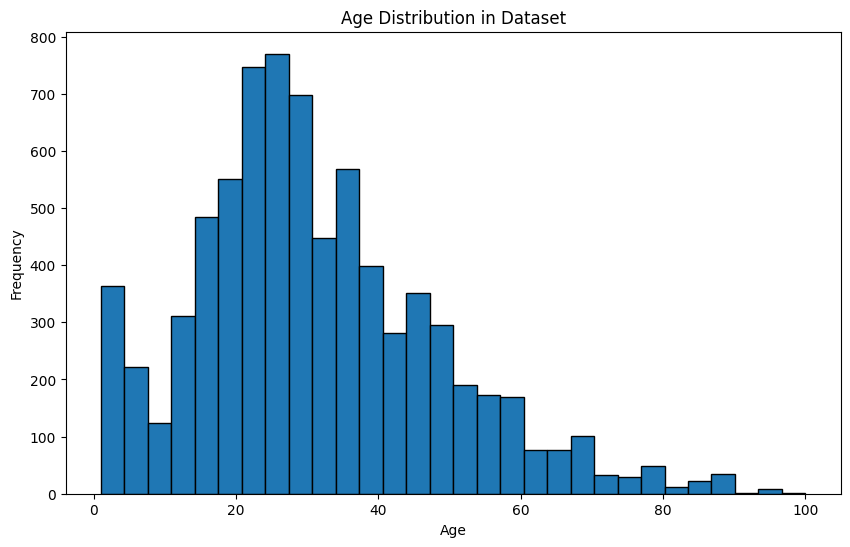

In [9]:
# plot age distribution

plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, edgecolor='k')
plt.title('Age Distribution in Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Take a Look at Images and Real Ages in Dataset

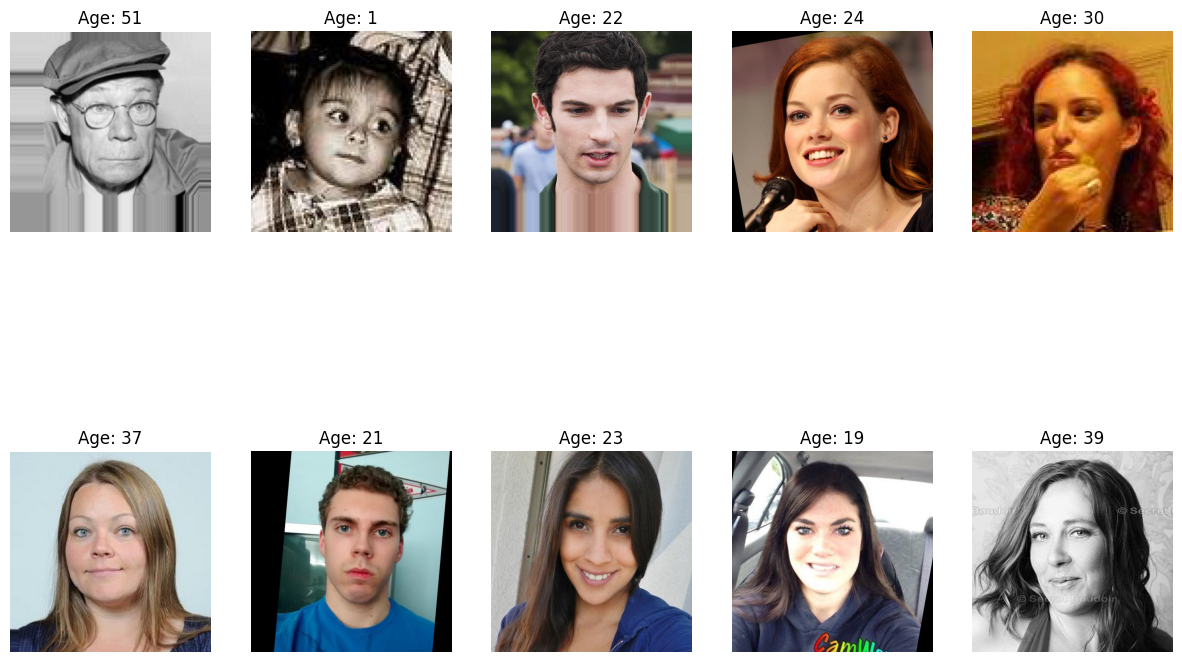

In [10]:
# Select random samples from the dataset
sample_indices = random.sample(range(len(labels)), 10)

plt.figure(figsize=(15, 10))
for i, index in enumerate(sample_indices, 1):
    plt.subplot(2, 5, i)
    image_path = '/datasets/faces/final_files/' + labels.loc[index, 'file_name']
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f"Age: {labels.loc[index, 'real_age']}")
    plt.axis('off')
plt.show()

### Findings

There are a couple of things to note about our dataset:

1. Our dataset covers a wide range of ages from 0-100. Most of the images are of people in the age range from about 15 - 39. There are significantly less images of the older age range compared to younger. 
 
2. Our dataset contains 7.6k images. It may be too small to train our deep learning model effectively without overfitting. We may need to augment some of the images to help it train more effectively. A few ideas would be to rotate and/or reflect images of the older ages to give the model more images to train with for that age group. 

3. The differences in image quality may make it harder for our model to train. We may need to do some augmenting steps such as sharpening blurry images to address this. 

4. We have no missing values and no duplicate entries.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [12]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    model = Sequential()
    model.add(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
       train_data,
       validation_data=test_data,
       batch_size=batch_size,
       epochs=epochs,
       steps_per_epoch=steps_per_epoch or len(train_data),
       validation_steps=validation_steps or len(test_data),
       verbose=2,
       shuffle=True)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [15]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

In the first set of epochs we can see the Loss and MAE values are steadily decreasing. This shows that our model is learning and improving on the training data and also performs well on the unseen data in the validation set. 

In the middle epochs we show continued decrease in Loss values and MAE improves, showing that our model is learning well. However, there is a fluctuation in the Loss and MAE values in epoch 12 which may suggest the model is starting to overfit. 

In the last portion of epochs we can see the Loss and MAE decreasing and improving for the most part, therefore, our model is learning effectively. 

Overall, we can say that yes, computer vision can help our customer in the case of predicting people's ages from images of their faces and Good Seed Supermarkets would be very pleased with this model.

This model can also be used to provide valuable insights for a number of applications including: 
- age based entry requirements
- target marketing
- demographic analysis
- personalized user experience.